<a href="https://colab.research.google.com/github/pritam-banik-roy/eCommerce_Data_Analysis/blob/main/Pritam_Banik_Roy_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Task 3: Customer Segmentation / Clustering**

# **Step 1: Load and Preprocess Data**

### **Load Data:**

In [ ]:
# Import necessary libraries
import pandas as pd

# Load datasets
customers = pd.read_csv('/content/Customers.csv')
transactions = pd.read_csv('/content/Transactions.csv')

# Preview datasets
print(customers.head())
print(transactions.head())


  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price  
0      300.68  300.68  
1      300.68  300.68  
2      300.68  300.68  
3      601.36  300.68  
4      902.04  300.68  



### **Preprocess and Aggregate Data:**

Combine customer profile and transaction data to create features for clustering

In [ ]:
# Convert date columns to datetime
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# Aggregate transaction data for each customer
transaction_aggregates = transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',  # Total spending
    'Quantity': 'sum',    # Total products purchased
    'TransactionID': 'count'  # Number of transactions
}).rename(columns={'TransactionID': 'TransactionCount'}).reset_index()

# Merge with customer profiles
customer_data = pd.merge(customers, transaction_aggregates, on='CustomerID', how='left').fillna(0)

# Preview processed data
print(customer_data.head())


  CustomerID        CustomerName         Region SignupDate  TotalValue  \
0      C0001    Lawrence Carroll  South America 2022-07-10     3354.52   
1      C0002      Elizabeth Lutz           Asia 2022-02-13     1862.74   
2      C0003      Michael Rivera  South America 2024-03-07     2725.38   
3      C0004  Kathleen Rodriguez  South America 2022-10-09     5354.88   
4      C0005         Laura Weber           Asia 2022-08-15     2034.24   

   Quantity  TransactionCount  
0      12.0               5.0  
1      10.0               4.0  
2      14.0               4.0  
3      23.0               8.0  
4       7.0               3.0  


# **Step 2: Feature Engineering**

### **Prepare the data for clustering:**

In [ ]:
# Select relevant features for clustering
features = customer_data[['TotalValue', 'Quantity', 'TransactionCount']]

# Normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Verify scaled data
print(scaled_features[:5])


[[-0.05188436 -0.1107351   0.        ]
 [-0.86271433 -0.43404927 -0.45129368]
 [-0.393842    0.21257907 -0.45129368]
 [ 1.03537505  1.66749283  1.35388105]
 [-0.76949861 -0.91902053 -0.90258736]]


# **Step 3: Apply Clustering**

### **Use K-Means Clustering:**

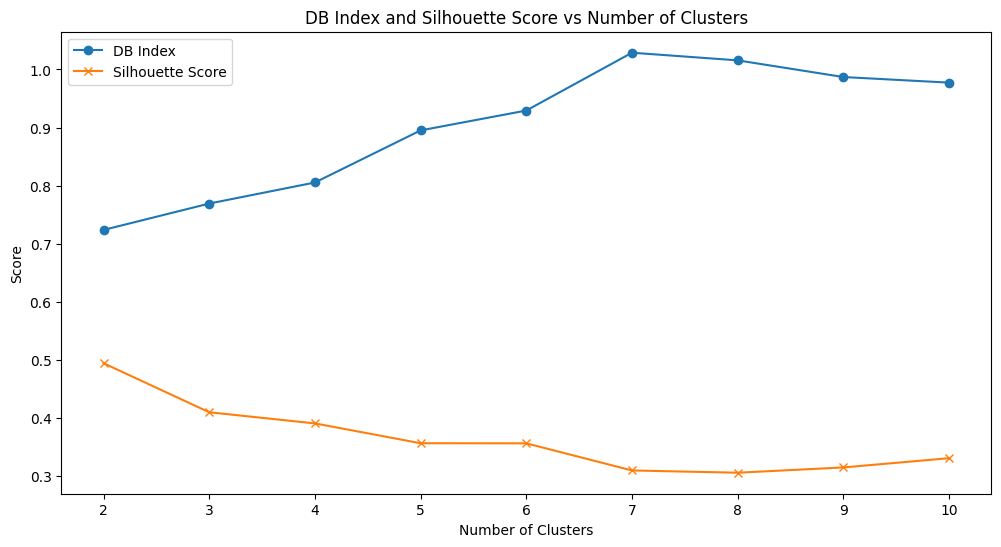

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score

# Determine the optimal number of clusters (2-10)
db_scores = []
silhouette_scores = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(scaled_features)

    # Compute Davies-Bouldin Index and Silhouette Score
    db_index = davies_bouldin_score(scaled_features, labels)
    silhouette_avg = silhouette_score(scaled_features, labels)

    db_scores.append(db_index)
    silhouette_scores.append(silhouette_avg)

# Plot metrics to choose optimal clusters
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(range(2, 11), db_scores, marker='o', label='DB Index')
plt.plot(range(2, 11), silhouette_scores, marker='x', label='Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('DB Index and Silhouette Score vs Number of Clusters')
plt.legend()
plt.show()


### **Fit K-Means with Optimal Clusters:**

In [ ]:
# Choose optimal number of clusters (based on lowest DB Index)
optimal_clusters = db_scores.index(min(db_scores)) + 2

# Fit K-Means with optimal clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(scaled_features)

# Preview clustered data
print(customer_data.head())


  CustomerID        CustomerName         Region SignupDate  TotalValue  \
0      C0001    Lawrence Carroll  South America 2022-07-10     3354.52   
1      C0002      Elizabeth Lutz           Asia 2022-02-13     1862.74   
2      C0003      Michael Rivera  South America 2024-03-07     2725.38   
3      C0004  Kathleen Rodriguez  South America 2022-10-09     5354.88   
4      C0005         Laura Weber           Asia 2022-08-15     2034.24   

   Quantity  TransactionCount  Cluster  
0      12.0               5.0        1  
1      10.0               4.0        1  
2      14.0               4.0        1  
3      23.0               8.0        0  
4       7.0               3.0        1  


# **Step 4: Visualize Clusters**

### **Plot Clusters:**

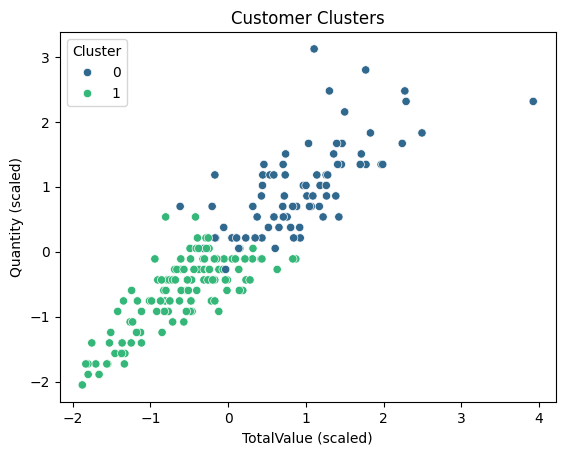

In [ ]:
import seaborn as sns

# 2D visualization of clusters
sns.scatterplot(
    x=scaled_features[:, 0], y=scaled_features[:, 1],
    hue=customer_data['Cluster'], palette='viridis'
)
plt.title('Customer Clusters')
plt.xlabel('TotalValue (scaled)')
plt.ylabel('Quantity (scaled)')
plt.show()


### **Cluster Sizes:**

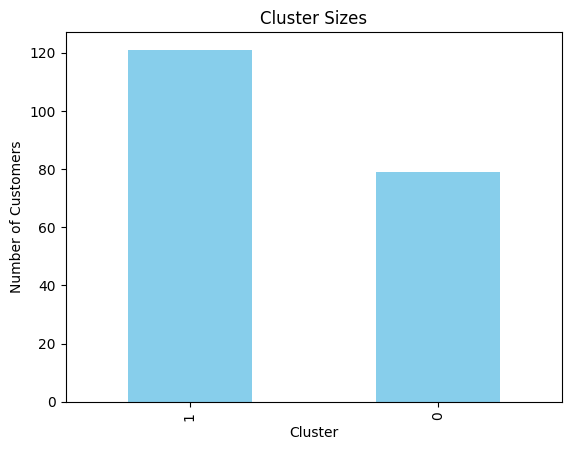

In [ ]:
# Plot cluster sizes
customer_data['Cluster'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Cluster Sizes')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()


# **Step 5: Report Clustering Metrics**

### **Compute Metrics:**

In [ ]:
# Compute final clustering metrics
db_index = davies_bouldin_score(scaled_features, customer_data['Cluster'])
silhouette_avg = silhouette_score(scaled_features, customer_data['Cluster'])

print(f'Davies-Bouldin Index: {db_index}')
print(f'Silhouette Score: {silhouette_avg}')


Davies-Bouldin Index: 0.7234787545050064
Silhouette Score: 0.49373487735321214


### **Cluster Profiling:**

In [ ]:
# Profile clusters
cluster_profiles = customer_data.groupby('Cluster').agg({
    'TotalValue': ['mean', 'sum'],
    'Quantity': ['mean', 'sum'],
    'TransactionCount': 'mean'
}).reset_index()

print(cluster_profiles)


  Cluster   TotalValue              Quantity         TransactionCount
                  mean        sum       mean     sum             mean
0       0  5155.752532  407304.45  18.721519  1479.0         7.113924
1       1  2336.290165  282691.11   8.743802  1058.0         3.619835
